In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import os,random, math, psutil, pickle    


In [2]:
train_df = pd.read_csv('./data/train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], 
                                       format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv('./data/weather_train.csv')

test_df = pd.read_csv('./data/test.csv')
weather_test_df = pd.read_csv('./data/weather_test.csv')
building_meta_df = pd.read_csv('./data/building_metadata.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [3]:
display(train_df.head())
display(weather_train_df.head())
display(building_meta_df.head())

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


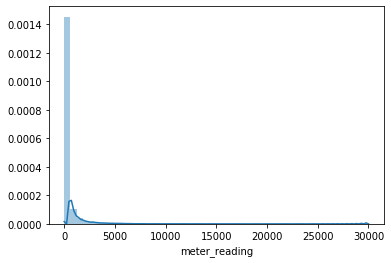

In [5]:
sns.distplot(train_df[train_df['meter_reading']<30000]['meter_reading'])

/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


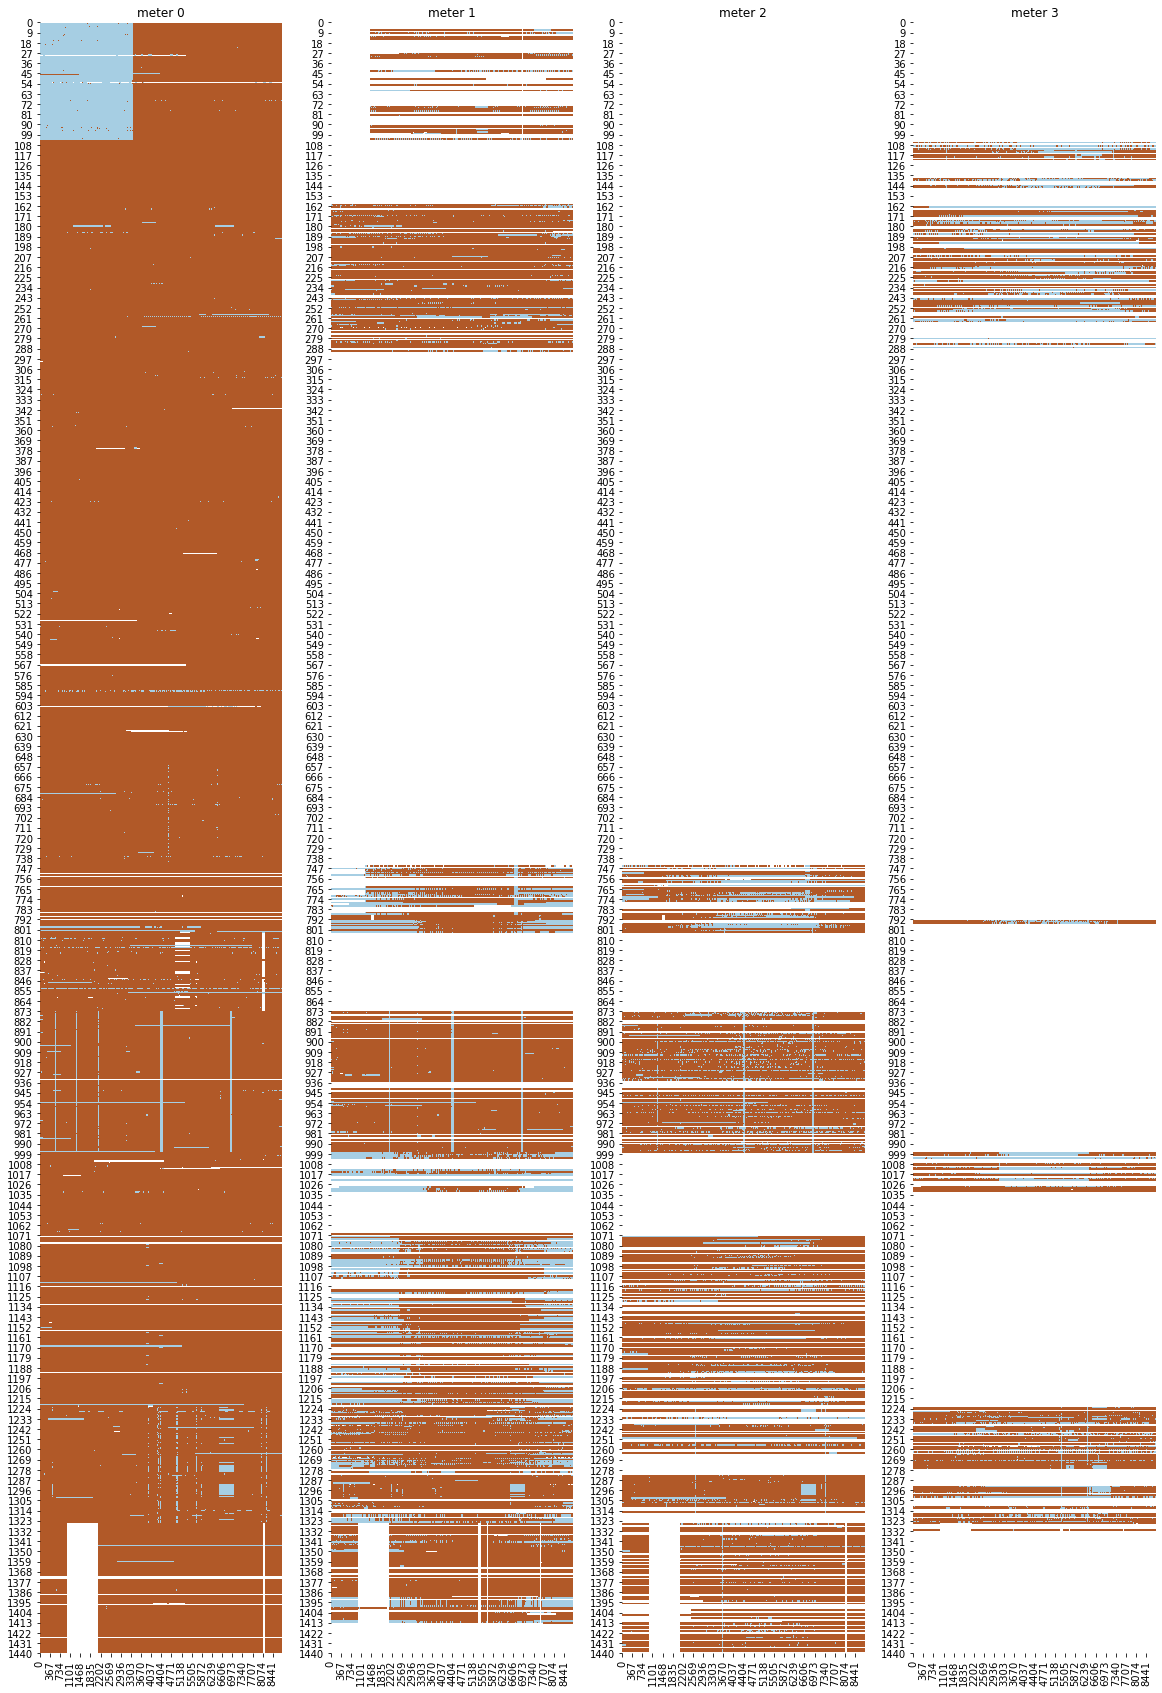

In [6]:
train = train_df.set_index(['timestamp'])

# Plot missing values per building/meter
f,a=plt.subplots(1,4,figsize=(20,30))
for meter in np.arange(4):
    df = train[train.meter==meter].copy().reset_index()
    df['timestamp'] = pd.to_timedelta(df.timestamp).dt.total_seconds() / 3600
    df['timestamp'] = df.timestamp.astype(int)
    df.timestamp -= df.timestamp.min()
    missmap = np.empty((1449, df.timestamp.max()+1))
    missmap.fill(np.nan)
    for l in df.values:
        if l[2]!=meter:continue
        missmap[int(l[1]), int(l[0])] = 0 if l[3]==0 else 1
    a[meter].set_title(f'meter {meter:d}')
    sns.heatmap(missmap, cmap='Paired', ax=a[meter], cbar=False)

In [7]:
# checking missing data
total = weather_train_df.isnull().sum().sort_values(ascending = False)
percent = (weather_train_df.isnull().sum()/weather_train_df.isnull().count()*100).sort_values(ascending = False)
missing_weather_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_data.head(9)

,Total,Percent
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
timestamp,0,0.000000
site_id,0,0.000000


In [8]:
# checking missing data
total = building_meta_df.isnull().sum().sort_values(ascending = False)
percent = (building_meta_df.isnull().sum()/building_meta_df.isnull().count()*100).sort_values(ascending = False)
missing_building_meta_df  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_building_meta_df.head(6)

,Total,Percent
floor_count,1094,75.500345
year_built,774,53.416149
square_feet,0,0.000000
primary_use,0,0.000000
building_id,0,0.000000
site_id,0,0.000000


In [9]:
corrs=train_df.corr()

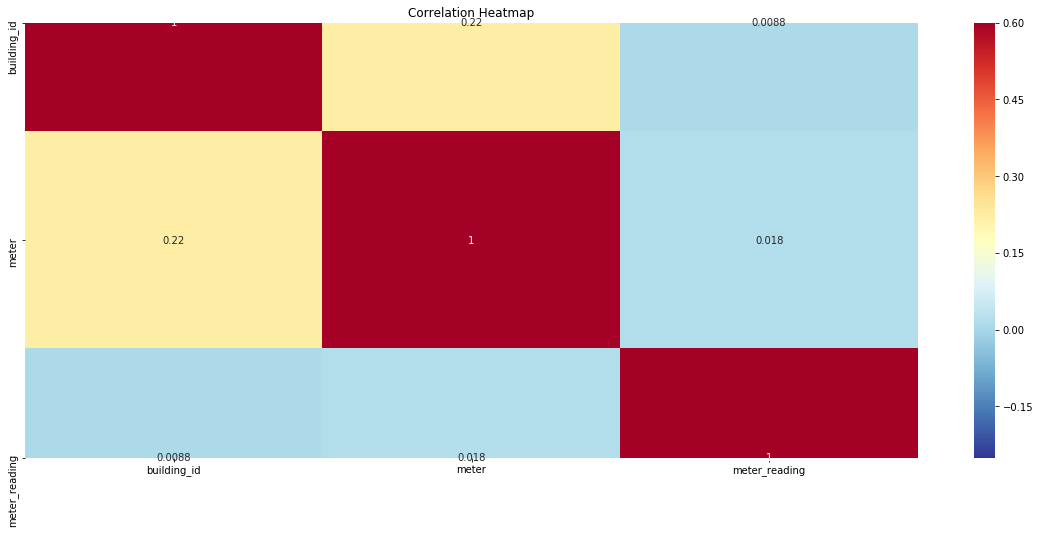

In [10]:
plt.figure(figsize = (20, 8))

# Heatmap of correlations
sns.heatmap(corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');


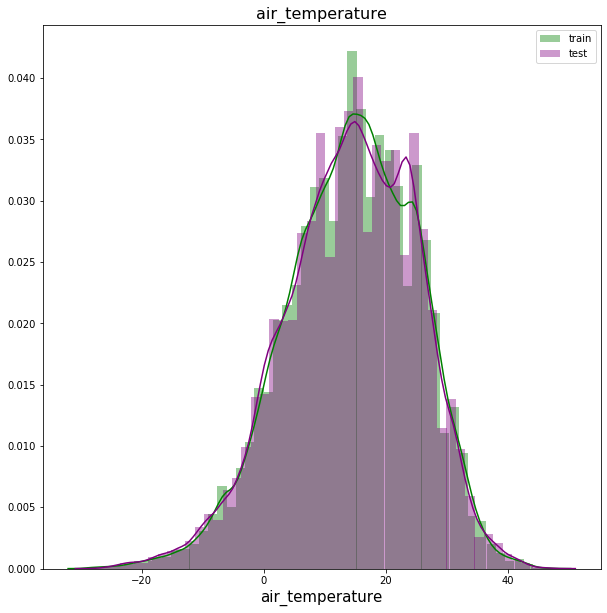

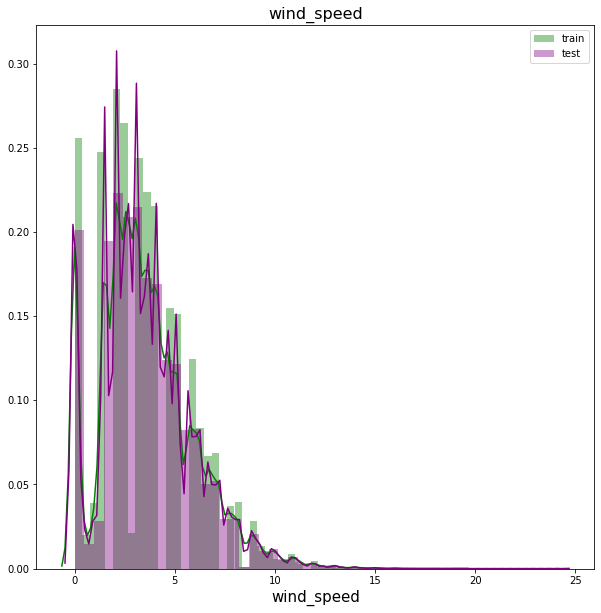

In [11]:
def plot_dist_col(column):
    '''plot dist curves for train and test weather data for the given column name'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(weather_train_df[column].dropna(), color='green', ax=ax).set_title(column, fontsize=16)
    sns.distplot(weather_test_df[column].dropna(), color='purple', ax=ax).set_title(column, fontsize=16)
    plt.xlabel(column, fontsize=15)
    plt.legend(['train', 'test'])
    plt.show()
    
plot_dist_col('air_temperature')
plot_dist_col('wind_speed')

In [12]:
train_df['meter'] = pd.Categorical(train_df['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
test_df['meter'] = pd.Categorical(test_df['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})

daily_train = train_df.copy()
daily_train['date'] = daily_train['timestamp'].dt.date
daily_train = daily_train.groupby(['date', 'building_id', 'meter']).sum()
daily_train

meter_reading
date       building_id meter                      
2016-01-01 0           electricity        0.000000
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN
           1           electricity        0.000000
...                                            ...
2016-12-31 1447        hotwater                NaN
           1448        electricity       79.974998
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN

[2121336 rows x 1 columns]

In [13]:
daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_agg = daily_train_agg.reset_index()
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2016-01-01,electricity,4.219648e+06,3037.903076,"(2016-01-01, 803, electricity)",1.160372e+05
1,2016-01-01,chilledwater,1.412169e+06,3090.084961,"(2016-01-01, 1289, chilledwater)",1.042116e+05
2,2016-01-01,steam,6.873201e+07,218891.734375,"(2016-01-01, 1099, steam)",5.095080e+07
3,2016-01-01,hotwater,1.609989e+06,11180.481445,"(2016-01-01, 1331, hotwater)",2.198245e+05
4,2016-01-02,electricity,4.288951e+06,3085.576416,"(2016-01-02, 803, electricity)",1.157768e+05


In [14]:
building_meta_df['primary_use'] = building_meta_df['primary_use'].astype('category')


In [15]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])
    
building_meta_df['primary_use'] = building_meta_df['primary_use'].astype('category')

temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']


#merging the reading df with the featurs of each house
temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')

del temp_df['building_id']
test_df = pd.concat([test_df, temp_df], axis=1)
del temp_df, building_meta_df

In [16]:
temp_df = train_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_train_df, on=['site_id','timestamp'], how='left')
del temp_df['site_id'], temp_df['timestamp']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_test_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
test_df = pd.concat([test_df, temp_df], axis=1)

del temp_df, weather_train_df, weather_test_df


In [17]:
train_df['age'] = train_df['year_built'].max() - train_df['year_built'] + 1
test_df['age'] = test_df['year_built'].max() - test_df['year_built'] + 1

In [18]:
train_df['month_datetime'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['weekofyear_datetime'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['dayofyear_datetime'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
    
train_df['hour_datetime'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_month_datetime'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_month_datetime'] = train_df['timestamp'].dt.day/7
train_df['week_month_datetime'] = train_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
train_df['year_built'] = train_df['year_built']-1900
train_df['square_feet'] = np.log(train_df['square_feet'])
    
test_df['month_datetime'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['weekofyear_datetime'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['dayofyear_datetime'] = test_df['timestamp'].dt.dayofyear.astype(np.int16)
    
test_df['hour_datetime'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['day_week'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['day_month_datetime'] = test_df['timestamp'].dt.day.astype(np.int8)
test_df['week_month_datetime'] = test_df['timestamp'].dt.day/7
test_df['week_month_datetime'] = test_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
test_df['year_built'] = test_df['year_built']-1900
test_df['square_feet'] = np.log(test_df['square_feet'])


train_df.drop(['timestamp', 'building_id', 'site_id'], inplace=True,
             axis=1)
test_df.drop(['timestamp', 'building_id', 'site_id', 'row_id'], inplace=True,
             axis=1)

In [19]:
print(train_df.columns)
print(train_df.dtypes)
display(train_df.head())

Index(['meter', 'meter_reading', 'primary_use', 'square_feet', 'year_built',
       'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'age', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime'],
      dtype='object')
meter                  category
meter_reading           float32
primary_use            category
square_feet             float64
year_built              float32
floor_count             float16
air_temperature         float16
cloud_coverage          float16
dew_temperature         float16
precip_depth_1_hr       float16
sea_level_pressure      float16
wind_direction          float16
wind_speed              float16
age                     float16
month_datetime             int8
weekofyear_datetime        int8
dayofyear_datetime        int16
hour_datetime              int8

,meter,meter_reading,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,...,wind_direction,wind_speed,age,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime
0,electricity,0.0,Education,8.913550,108.0,NaN,25.0,6.0,20.0,NaN,...,0.0,0.0,10.0,1,53,1,0,4,1,1
1,electricity,0.0,Education,7.908387,104.0,NaN,25.0,6.0,20.0,NaN,...,0.0,0.0,14.0,1,53,1,0,4,1,1
2,electricity,0.0,Education,8.589700,91.0,NaN,25.0,6.0,20.0,NaN,...,0.0,0.0,27.0,1,53,1,0,4,1,1
3,electricity,0.0,Education,10.072597,102.0,NaN,25.0,6.0,20.0,NaN,...,0.0,0.0,16.0,1,53,1,0,4,1,1
4,electricity,0.0,Education,11.666565,75.0,NaN,25.0,6.0,20.0,NaN,...,0.0,0.0,43.0,1,53,1,0,4,1,1


In [20]:
for col in train_df:
    if str(train_df[col].dtype) == 'category' or \
    str(train_df[col].dtype) == 'object':

        train_df = pd.concat((train_df, pd.get_dummies(train_df[col], 
                                           prefix=col+"_")), axis=1)

        train_df.drop(col, axis=1, inplace=True)
        
for col in test_df:
    if str(test_df[col].dtype) == 'category' or \
    str(test_df[col].dtype) == 'object':

        test_df = pd.concat((test_df, pd.get_dummies(test_df[col], 
                                           prefix=col+"_")), axis=1)

        test_df.drop(col, axis=1, inplace=True)
train_df.dropna(axis=0, inplace=True)
test_df.dropna(axis=0, inplace=True)

In [21]:
display(train_df.head())
display(test_df.head())
y_train =train_df['meter_reading']
train_df.drop('meter_reading', axis=1, inplace=True)

,meter_reading,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,...,primary_use__Office,primary_use__Other,primary_use__Parking,primary_use__Public services,primary_use__Religious worship,primary_use__Retail,primary_use__Services,primary_use__Technology/science,primary_use__Utility,primary_use__Warehouse/storage
3021,8.500000,9.637306,54.0,2.0,9.398438,0.0,-2.199219,0.0,1021.5,360.0,...,0,0,0,0,0,0,0,0,0,0
3022,0.521000,7.605890,57.0,1.0,9.398438,0.0,-2.199219,0.0,1021.5,360.0,...,0,0,0,0,0,0,0,0,0,0
3023,243.500000,11.363160,64.0,8.0,9.398438,0.0,-2.199219,0.0,1021.5,360.0,...,0,0,0,0,0,0,0,0,0,0
3024,79.487999,12.171492,64.0,10.0,9.398438,0.0,-2.199219,0.0,1021.5,360.0,...,0,0,0,0,0,0,0,0,0,0
3025,16.750000,10.777997,80.0,3.0,9.398438,0.0,-2.199219,0.0,1021.5,360.0,...,0,0,0,0,0,0,0,0,0,0


,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,...,primary_use__Office,primary_use__Other,primary_use__Parking,primary_use__Public services,primary_use__Religious worship,primary_use__Retail,primary_use__Services,primary_use__Technology/science,primary_use__Utility,primary_use__Warehouse/storage
13212099,9.637306,54.0,2.0,10.0,2.0,5.0,0.0,1014.0,280.0,3.099609,...,0,0,0,0,0,0,0,0,0,0
13212100,7.605890,57.0,1.0,10.0,2.0,5.0,0.0,1014.0,280.0,3.099609,...,0,0,0,0,0,0,0,0,0,0
13212101,11.322612,116.0,4.0,10.0,2.0,5.0,0.0,1014.0,280.0,3.099609,...,0,0,0,0,0,0,0,0,0,0
13212102,9.557470,74.0,2.0,10.0,2.0,5.0,0.0,1014.0,280.0,3.099609,...,0,0,0,0,0,0,0,0,0,0
13212103,11.363160,64.0,8.0,10.0,2.0,5.0,0.0,1014.0,280.0,3.099609,...,0,0,0,0,0,0,0,0,0,0


Mean, STD of readings: 179.57086181640625, 286.361572265625


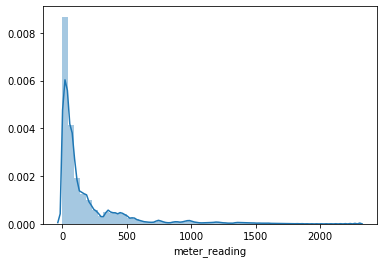

In [22]:
sns.distplot(y_train)
print(f"Mean, STD of readings: {y_train.mean()}, {y_train.std()}")

In [24]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

for num_est in [10, 20]:
    for depth in [5, 10, 20]:
        reg = RandomForestRegressor(n_estimators =num_est, 
                                    max_depth = depth,
                                    random_state=123)

        scores = cross_val_score(reg, train_df.values, y_train, 
                             cv=3, scoring='neg_mean_squared_error')


        rmse = (np.sqrt(np.asarray(scores)*-1)).sum()

        print(f"RMSE for {num_est}, {depth} is {rmse}")


RMSE for 10, 5 is 243.48002587527372
RMSE for 10, 10 is 124.39910121867746
RMSE for 10, 20 is 107.41305190813877
RMSE for 20, 5 is 242.57037546109888
RMSE for 20, 10 is 123.68280277539913
RMSE for 20, 20 is 105.18462909005952


In [ ]:
from sklearn.kernel_ridge import KernelRidge

reg = KernelRidge(kernel='rbf')

scores = cross_val_score(reg, train_df.values[:50000], 
                         y_train[:50000]
, 
                     cv=3, scoring='neg_mean_squared_error')


rmse = (np.sqrt(np.asarray(scores)*-1)).sum()

print(f"RMSE is {rmse}")
